In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pylab
import numpy as np
import scipy.io
import scipy.stats
import datetime
import pandas as pd
import matplotlib as mpl
import math

%matplotlib inline
from scipy.stats import stats
from IPython.display import display
from glob import glob

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve
from scipy.stats import scoreatpercentile
from sklearn.datasets.samples_generator import make_regression
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.linear_model.ridge import Ridge
from sklearn.linear_model.stochastic_gradient import SGDRegressor
from sklearn.svm.classes import SVR
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
# load date format and using 2011-01-24 as the day 1
from datetime import datetime
date_format = "%Y-%m-%d"
day1 = datetime.strptime('2011-01-23',date_format)
daylast = datetime.strptime('2015-12-13',date_format)

## Load original csv file as dataframe

In [4]:
emp_retention = pd.read_csv('./employee_retention_data.csv',header = 0) # emp is short for employee 

## Making a table with all companies and head count for all days

In [5]:
# Sort all data with company id and join date
emp_retention_sorted = emp_retention.sort_values(['company_id','join_date'])

# Create head count with +1 and -1 
emp_retention_sorted['join_date_head_count'] = 1
emp_retention_sorted['quit_date_head_count'] = -1

all_company_headcount = pd.DataFrame()

for company_num in range(1,13): # Total 12 companies 
    each_company = emp_retention_sorted[emp_retention_sorted.company_id == company_num]
    
    topdf = each_company[['join_date','join_date_head_count']]
    bottomdf = each_company[['quit_date','quit_date_head_count']]
    topdf.columns = ['date' , 'head_count']
    bottomdf.columns = topdf.columns
    # append join date with quit date columns
    day_headcount = topdf.append([bottomdf])
    day_headcount.sort_values('date',inplace = True)
    # caculate the head count for each date 
    agg_day_headcount = day_headcount.groupby('date').sum()
    
    day_column = []

    for each_date in agg_day_headcount.index:
        # Convert year-month-date format to day number 
        delta = datetime.strptime(each_date,date_format) - day1
        day_column.append(delta.days)

    agg_day_headcount['day_num'] = day_column
    agg_day_headcount['employee_headcount'] = agg_day_headcount['head_count'].cumsum()
    agg_day_headcount.drop('head_count', 1, inplace = True)
    agg_day_headcount['company_id'] = company_num
    all_company_headcount = all_company_headcount.append([agg_day_headcount], ignore_index = True)

all_company_headcount.sort_values('day_num',inplace = True)
all_company_headcount.set_index('company_id',inplace = True)

#### Plot head counts vs day number for all companies

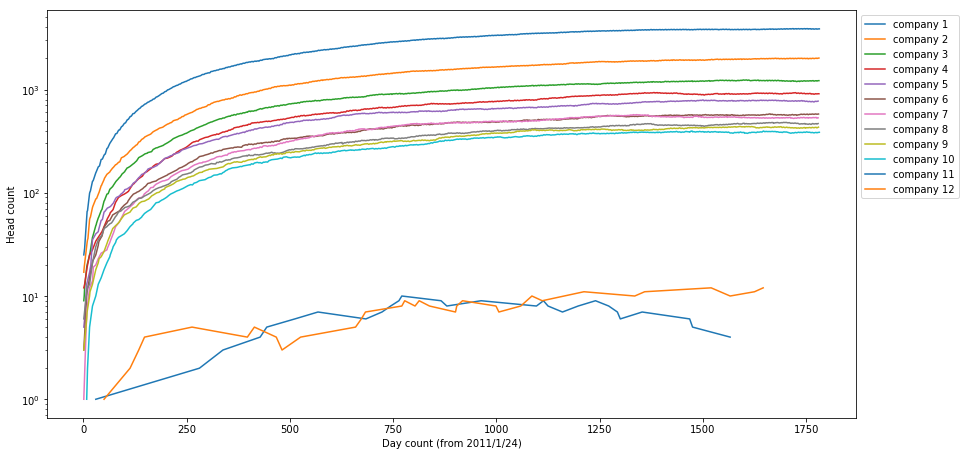

In [6]:
companylegend = []
for i in range(1,13):
    companylegend += plt.plot(all_company_headcount['day_num'].loc[i], 
             all_company_headcount['employee_headcount'].loc[i], 
            label = 'company %s' %i)
plt.legend(handles = companylegend, bbox_to_anchor = (1,1))
plt.yscale('log')
plt.xlabel('Day count (from 2011/1/24)')
plt.ylabel('Head count')
fig = plt.gcf()
fig.set_size_inches(14.5,7.5)
plt.show()

In [62]:
# Saving the csv file 
all_company_headcount.to_csv('./all_company_headcount.csv', header = True, index = True)

## Clean up the features for emp_retention_sorted

In [7]:
# Reload the data again to avoid unwanted changes 
emp_retention = pd.read_csv('./employee_retention_data.csv',header = 0) # emp is short for employee 
emp_retention_sorted = emp_retention.sort_values(['company_id','join_date'])
#emp_retention_sorted.drop('employee_id', 1, inplace = True)
emp_retention_sorted.set_index('company_id', inplace = True)

### Convert date format to day # starting 2011/1/23

In [8]:
join_date_column = []
for each_date in emp_retention_sorted['join_date'].values:
    delta1 = datetime.strptime(each_date,date_format) - day1
    join_date_column.append(delta1.days)

In [9]:
quit_date_column = []
for each_date in emp_retention_sorted['quit_date'].values:
    # Check whether quit date is NaN, if so put quit day to be 20000 days (55 years)
    if each_date != each_date:
        quit_date_column.append(20000)  
    else:
        delta2 = datetime.strptime(each_date,date_format) - day1
        quit_date_column.append(delta2.days)

In [10]:
emp_retention_sorted['join_day'] = join_date_column
emp_retention_sorted['quit_day'] = quit_date_column
emp_retention_sorted.drop(['join_date','quit_date'], 1, inplace = True)
emp_retention_sorted['delta_day'] = emp_retention_sorted['quit_day'] - emp_retention_sorted['join_day']

##### Check if days with the company correlate with salary 

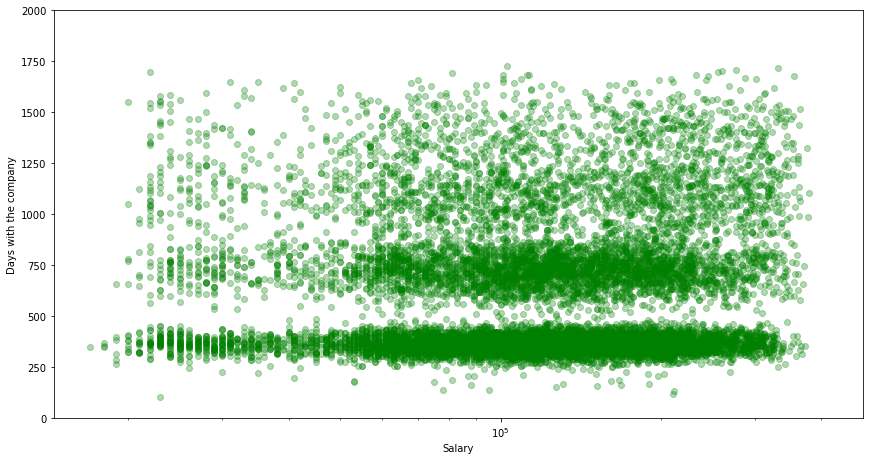

In [115]:
plt.scatter(emp_retention_sorted['salary'], emp_retention_sorted['delta_day'], color = 'g', alpha=0.3)
plt.ylim([0,2000])
plt.xscale('log')
plt.xlabel('Salary')
plt.ylabel('Days with the company')
fig = plt.gcf()
fig.set_size_inches(14.5,7.5)

### normalize all variables for company of choice

In [39]:
# Enumerate department into numbers 
dept = pd.factorize(emp_retention_sorted['dept'])
emp_retention_sorted['dept_enu'] = dept[0]
emp_retention_sorted['norm_join'] = emp_retention_sorted['join_day'] / ((daylast-day1).days)
emp_retention_sorted['norm_quit'] = emp_retention_sorted['quit_day'] / ((daylast-day1).days)
# take out company 1-10 data and normalize their salary and seniorities 
X_data = emp_retention_sorted.ix[1:10,[2,3,7,8]]
y_norm = emp_retention_sorted.ix[1:10,6].to_frame()

/Users/liyixu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


(0, 5000)

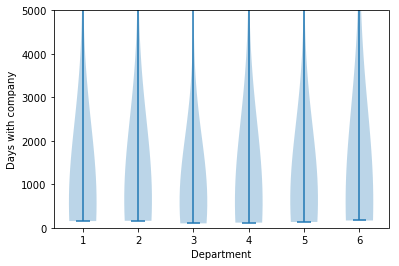

In [114]:
plt.violinplot([emp_retention_sorted['delta_day'].loc[emp_retention_sorted['dept']=='sales'], 
                emp_retention_sorted['delta_day'].loc[emp_retention_sorted['dept']=='data_science'], 
                emp_retention_sorted['delta_day'].loc[emp_retention_sorted['dept']=='customer_service'], 
                emp_retention_sorted['delta_day'].loc[emp_retention_sorted['dept']=='marketing'], 
                emp_retention_sorted['delta_day'].loc[emp_retention_sorted['dept']=='engineer'], 
                emp_retention_sorted['delta_day'].loc[emp_retention_sorted['dept']=='design']])
plt.xlabel('Department')
plt.ylabel('Days with company')
plt.ylim([0,5000])

In [64]:
X_data['norm_salary'] = \
(X_data['salary'] - min(X_data['salary'])) \
/ (max(X_data['salary']) - min(X_data['salary']))

X_data['norm_seniority'] = \
(X_data['seniority'] - min(X_data['seniority'])) \
/ (max(X_data['seniority']) - min(X_data['seniority']))

X_data['norm_dept'] = \
(X_data['dept_enu'] - min(X_data['dept_enu'])) \
/ (max(X_data['dept_enu']) - min(X_data['dept_enu']))

X_norm = X_data.drop(['seniority','salary','dept_enu'], 1)

#### Check if days with the company correlate with department and salary

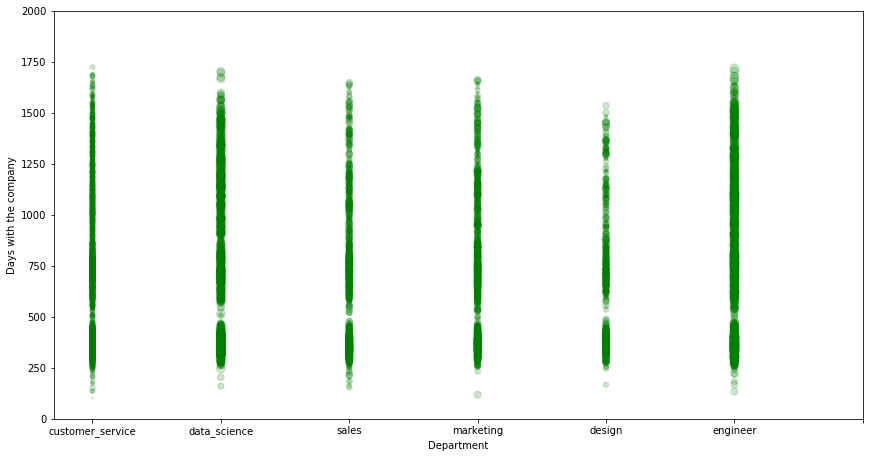

In [81]:
plt.scatter(X_norm['norm_dept'], y_norm['delta_day'], color = 'g', alpha=0.2, s=X_norm['norm_salary']*100)
plt.ylim([0,2000])
#plt.yscale('log')
plt.xlabel('Department')
plt.ylabel('Days with the company')
loc,label = plt.xticks()
plt.xticks(loc[0:-1]+0.2, ['customer_service', 'data_science', 'sales', 'marketing', 'design','engineer'])
fig = plt.gcf()
fig.set_size_inches(14.5,7.5)

#### Check if days with the company correlate with seniority and salary

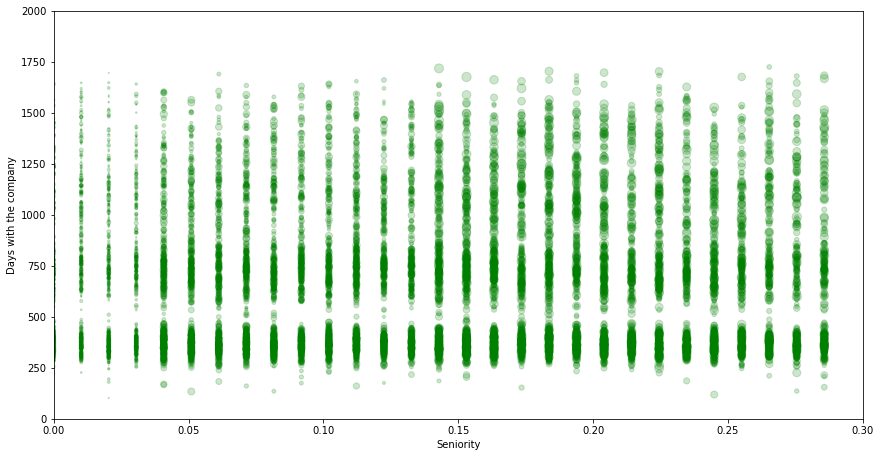

In [94]:
plt.scatter(X_norm['norm_seniority'], y_norm['delta_day'], color = 'g', alpha=0.2, s=X_norm['norm_salary']*100)
#plt.violinplot(X_norm['norm_seniority'])
plt.ylim([0,2000])
plt.xlim([0,0.3])
#plt.yscale('log')
plt.xlabel('Seniority')
plt.ylabel('Days with the company')
loc,label = plt.xticks()
#plt.xticks(loc, ['customer_service', 'data_science', 'sales', 'marketing', 'design','engineer'])
fig = plt.gcf()
fig.set_size_inches(14.5,7.5)

### Try predictive models 

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X_norm[['norm_join','norm_salary','norm_seniority','norm_dept']]
                                                    , y_norm['delta_day']
                                                    , test_size=0.5
                                                    , random_state=6)

### Try logistic regression

In [283]:
lr = LogisticRegression(C=2)
model = lr.fit (X_train, y_train)
preds = lr.predict (X_test)
report = classification_report (y_test, preds)
#print(report)
print("Score:", model.score(X_test, y_test))

Score: 0.0171924418133


/Users/lilyxly/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Try random forest

In [280]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=50)
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.35160351056855299

### Try using boosted decision tree model 

In [117]:
#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.6, max_depth=1, random_state=0).fit(X_train, y_train)
#clf.score(X_test, y_test)